In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls -l /content/gdrive/'My Drive'/'Colab Notebooks'/data/images/pro |wc -l
pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

SyntaxError: ignored

In [3]:
#!pip install tensorflow --upgrade
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torch import nn
import torch
import pandas as pd
import os
import os.path
from PIL import Image
from torchvision import models
from tensorflow import summary
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torchsummary
import datetime
%load_ext tensorboard

In [0]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [0]:
class ZebraDataset(Dataset):
  def __init__(self, path,transform = None):
    self.transform = transform
    self.path = path
    self.data = []
    onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    #print(len(onlyfiles))
    onlyfiles.sort()
    #len(onlyfiles)
    onlyfiles = onlyfiles[1:]
    #
    csv = pd.read_csv(path + "SightingData.csv")
    idx=0
    for f in onlyfiles:
      self.data.append([f,csv["flank"][idx]])
      idx-=-1
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,id):
    file = Image.open(self.path+self.data[id][0]).convert('RGB')
    direc = 0
    if self.data[id][1]=='right':
      direc = 1
    if self.transform:
      file = self.transform(file)
    return file, direc

In [0]:
p = "/content/gdrive/My Drive/Colab Notebooks/data/images/gray/"
trans = transforms.Compose(
   [ transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])]
    )

t = ZebraDataset(p, transform=trans)

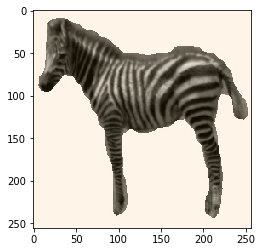

In [0]:
t.__getitem__(38)[0].shape
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
imshow(t.__getitem__(38)[0])

In [0]:
shuffle     = True
batch_size  = 16
num_workers = 2
validation_split = .2
shuffle_dataset = True
random_seed= 47

# Creating data indices for training and validation splits:
dataset_size = len(t)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
trainl  = DataLoader(dataset=t, 
                         #shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers, pin_memory = True, sampler = train_sampler)
testl =  DataLoader(dataset=t, 
                         #shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers, pin_memory = True, sampler = valid_sampler)
tmp = next(iter(dataloader))
len(tmp[1])
tmp[0].shape

torch.Size([64, 3, 256, 256])

In [0]:
tmp = next(iter(trainl))
len(tmp[1])
tmp[0].shape

torch.Size([16, 3, 256, 256])

In [0]:
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)

all_frozen(model.parameters())
def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False
model = models.resnet34(pretrained=True).to('cuda')
torchsummary.summary(res, (3, 256, 256), device="cuda")
res

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in res.parameters():
    param.requires_grad = False
freeze_all(res.parameters())
assert all_frozen(res.parameters())

In [0]:
n_classes = 2
model.fc = nn.Linear(512, n_classes)
model.

In [0]:
all_frozen(model.parameters())
criterion = nn.CrossEntropyLoss()


In [0]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)
DEVICE = 'cuda'
model = model.to(DEVICE)

In [0]:
def train():
  N_EPOCHS = 16

  for epoch in range(N_EPOCHS):
      
      # Train
      model.train()  # IMPORTANT
      
      total_loss, n_correct, n_samples = 0.0, 0, 0
      for batch_i, (X, y) in enumerate(trainl):
          X, y = X.to(DEVICE), y.to(DEVICE)
          
          optimizer.zero_grad()
          y_ = model(X)
          loss = criterion(y_, y)
          loss.backward()
          optimizer.step()
          
          # Statistics
          # print(
          #     f"Epoch {epoch+1}/{N_EPOCHS} |"
          #     f"  batch: {batch_i} |"
          #     f"  batch loss:   {loss.item():0.3f}"
          #)
          _, y_label_ = torch.max(y_, 1)
          n_correct += (y_label_ == y).sum().item()
          total_loss += loss.item() * X.shape[0]
          n_samples += X.shape[0]
      
      print(
          f"Epoch {epoch+1}/{N_EPOCHS} |"
          f"  train loss: {total_loss / n_samples:9.3f} |"
          f"  train acc:  {n_correct / n_samples * 100:9.3f}%"
      )
      
      
      # Eval
      model.eval()  # IMPORTANT
      
      total_loss, n_correct, n_samples = 0.0, 0, 0
      with torch.no_grad():  # IMPORTANT
          for X, y in testl:
              X, y = X.to(DEVICE), y.to(DEVICE)
                      
              y_ = model(X)
          
              # Statistics
              _, y_label_ = torch.max(y_, 1)
              n_correct += (y_label_ == y).sum().item()
              loss = criterion(y_, y)
              total_loss += loss.item() * X.shape[0]
              n_samples += X.shape[0]

      
      print(
          f"Epoch {epoch+1}/{N_EPOCHS} |"
          f"  valid loss: {total_loss / n_samples:9.3f} |"
          f"  valid acc:  {n_correct / n_samples * 100:9.3f}%"
      )

In [0]:
t = next(iter(testl))
#model.eval()

In [0]:
_,a = torch.max(model(t[0].to(DEVICE)),1)
model(t[0].to(DEVICE))
a

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')

In [0]:
t[1]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [0]:
for X, y in testl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            total_loss = 0.0     
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            n_correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            total_loss += loss.item() * X.shape[0]
            n_samples += X.shape[0]
            print(
        f"  valid loss: {total_loss / n_samples:9.3f} |"
        f"  valid acc:  {n_correct / n_samples * 100:9.3f}%"
    )


  valid loss:     0.004 |  valid acc:     96.850%
  valid loss:     0.001 |  valid acc:     96.947%
  valid loss:     0.000 |  valid acc:     97.037%
  valid loss:     0.000 |  valid acc:     97.122%
  valid loss:     0.001 |  valid acc:     97.203%
  valid loss:     0.016 |  valid acc:     96.939%
  valid loss:     0.000 |  valid acc:     97.020%
  valid loss:     0.000 |  valid acc:     97.097%
  valid loss:     0.008 |  valid acc:     97.013%
  valid loss:     0.011 |  valid acc:     96.933%
  valid loss:     0.000 |  valid acc:     96.951%


In [0]:
torchsummary.summary(model,(3, 256, 256),16, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 128, 128]           9,408
       BatchNorm2d-2         [16, 64, 128, 128]             128
              ReLU-3         [16, 64, 128, 128]               0
         MaxPool2d-4           [16, 64, 64, 64]               0
            Conv2d-5           [16, 64, 64, 64]          36,864
       BatchNorm2d-6           [16, 64, 64, 64]             128
              ReLU-7           [16, 64, 64, 64]               0
            Conv2d-8           [16, 64, 64, 64]          36,864
       BatchNorm2d-9           [16, 64, 64, 64]             128
             ReLU-10           [16, 64, 64, 64]               0
       BasicBlock-11           [16, 64, 64, 64]               0
           Conv2d-12           [16, 64, 64, 64]          36,864
      BatchNorm2d-13           [16, 64, 64, 64]             128
             ReLU-14           [16, 64,